In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


In [6]:
df = pd.read_csv("/content/training.csv").drop("breast_cancer_diagnosis_code",axis=1)
tdf = pd.read_csv("/content/test.csv").drop("breast_cancer_diagnosis_code",axis=1)
ss = pd.read_csv("/content/sample_submission.csv")

In [7]:
df

,patient_id,patient_race,payer_type,patient_state,patient_zip3,patient_age,patient_gender,bmi,breast_cancer_diagnosis_desc,metastatic_cancer_diagnosis_code,...,disabled,poverty,limited_english,commute_time,health_uninsured,veteran,Ozone,PM25,N02,DiagPeriodL90D
0,475714,NaN,MEDICAID,CA,924,84,F,NaN,Malignant neoplasm of unsp site of unspecified...,C7989,...,12.871429,22.542857,10.100000,27.814286,11.200000,3.500000,52.237210,8.650555,18.606528,1
1,349367,White,COMMERCIAL,CA,928,62,F,28.49,Malig neoplm of upper-outer quadrant of right ...,C773,...,8.957576,10.109091,8.057576,30.606061,7.018182,4.103030,42.301121,8.487175,20.113179,1
2,138632,White,COMMERCIAL,TX,760,43,F,38.09,Malignant neoplasm of central portion of left ...,C773,...,11.253333,9.663333,3.356667,31.394915,15.066667,7.446667,40.108207,7.642753,14.839351,1
3,617843,White,COMMERCIAL,CA,926,45,F,NaN,Malig neoplasm of upper-inner quadrant of left...,C773,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,0
4,817482,NaN,COMMERCIAL,ID,836,55,F,NaN,"Malignant neoplasm of breast (female), unspeci...",C773,...,15.276000,11.224000,1.946000,26.170213,12.088000,13.106000,41.356058,4.110749,11.722197,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,674178,White,NaN,OH,436,50,F,32.11,Malig neoplm of upper-outer quadrant of right ...,C773,...,17.400000,23.600000,0.864706,19.841176,6.300000,6.247059,38.753055,8.068682,21.140731,1
12902,452909,NaN,COMMERCIAL,CA,945,50,F,NaN,Malignant neoplasm of unspecified site of left...,C773,...,11.243210,7.837037,5.411250,34.700000,3.845679,5.671605,36.469947,6.265266,10.728732,1
12903,357486,NaN,COMMERCIAL,CA,926,61,F,29.24,Malignant neoplasm of unspecified site of left...,C7931,...,8.845238,8.688095,5.280952,27.561905,4.404762,4.809524,42.070075,7.229393,15.894123,1
12904,935417,NaN,NaN,NY,112,37,F,31.00,"Malignant neoplasm of breast (female), unspeci...",C773,...,10.194737,18.642105,14.173684,42.502632,6.392105,1.755263,37.722740,7.879795,27.496367,0


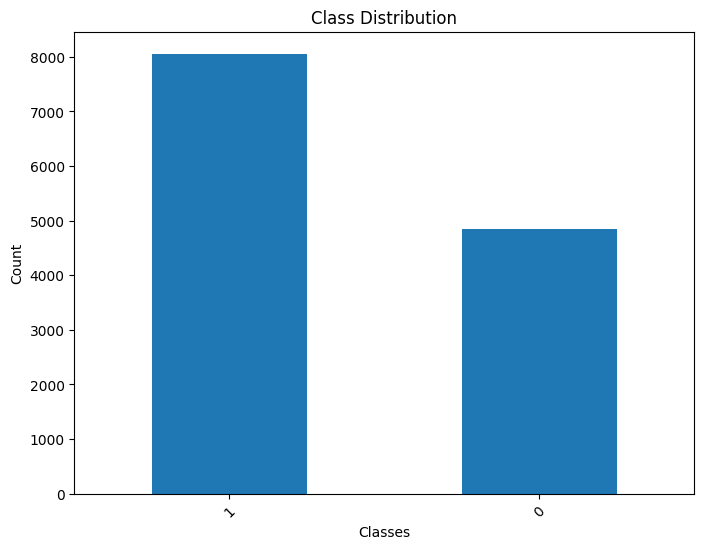

In [8]:

target = "DiagPeriodL90D"

# Count the occurrences of each class
class_counts = df[target].value_counts()

# Plot the class distribution
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [9]:
#  Find Product of Pollutants
df["N02xOzonexPM25"]=df["N02"]*df["Ozone"]*df["PM25"]
tdf["N02xOzonexPM25"]=tdf["N02"]*tdf["Ozone"]*tdf["PM25"]

In [11]:
columns_to_iterate = [col for col in df.columns if col not in ["patient_zip3", "N02xOzonexPM25"]]

for col in columns_to_iterate:

    df["check"]=df.groupby(["patient_zip3","N02xOzonexPM25"])[col].transform("nunique")
    if df["check"].max()==1:
        print("dropped ",col)
        df=df.drop(col,axis=1)
        tdf=tdf.drop(col,axis=1)
df=df.drop("check",axis=1)

In [12]:
cat_cols = list(tdf.columns[tdf.dtypes=="object"])
cols = [col for col in tdf.columns if col not in ["patient_id"]]
tdf[target] = np.nan

In [13]:
df = pd.concat([df,tdf[df.columns]],axis=0)

In [14]:
df["clust"]=(df.metastatic_cancer_diagnosis_code.str.len()==4).astype("int")
df["is_female"] = df.breast_cancer_diagnosis_desc.str.contains("female").astype("int")
df["is_female"].value_counts()

,count
is_female,
1,18665
0,33


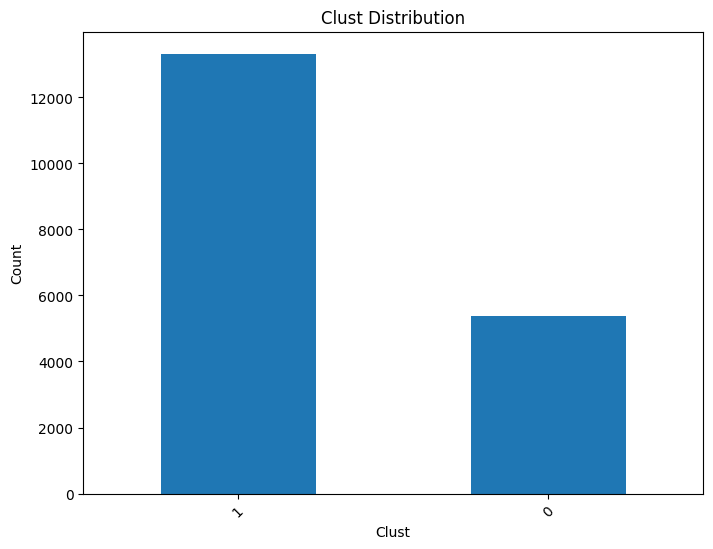

In [15]:
# Count the occurrences of each class
clust_counts = df["clust"].value_counts()

# Plot the clust distribution
plt.figure(figsize=(8, 6))
clust_counts.plot(kind='bar')
plt.title('Clust Distribution')
plt.xlabel('Clust')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [16]:
# do one-hot encoding for some features
age_cols = list(df.filter(regex="age").columns)
cols = list(set(cols)-set(age_cols))
income_cols = list(df.filter(regex="income").columns)
cols = list(set(cols)-set(income_cols))
cols = list(set(cols)-{"breast_cancer_diagnosis_code","N02xOzonexPM25","bmi"})
df=pd.get_dummies(df,columns=cols,dtype="int",drop_first=True)
cols

['metastatic_cancer_diagnosis_code',
 'breast_cancer_diagnosis_desc',
 'Division',
 'patient_race',
 'payer_type',
 'patient_zip3',
 'Region',
 'patient_state']

In [17]:
# do label encoding for categorical columns
le=LabelEncoder()
for col in cat_cols:
    try:
        df[col]=le.fit_transform(df[col]).astype("int")
        print(col)
    except:
        continue

In [18]:
tdf=df[df[target].isna()]
df=df[df[target].notna()]
len(df),len(tdf)

(12906, 5792)

In [19]:
df

,patient_id,patient_age,bmi,DiagPeriodL90D,N02xOzonexPM25,clust,is_female,metastatic_cancer_diagnosis_code_C771,metastatic_cancer_diagnosis_code_C772,metastatic_cancer_diagnosis_code_C773,...,patient_state_SC,patient_state_SD,patient_state_TN,patient_state_TX,patient_state_UT,patient_state_VA,patient_state_WA,patient_state_WI,patient_state_WV,patient_state_WY
0,475714,84,NaN,1.0,8407.933786,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,349367,62,28.49,1.0,7220.973636,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,138632,43,38.09,1.0,4548.811991,1,1,0,0,1,...,0,0,0,1,0,0,0,0,0,0
3,617843,45,NaN,0.0,4834.055964,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,817482,55,NaN,0.0,1992.824702,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12901,674178,50,32.11,1.0,6610.412744,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
12902,452909,50,NaN,1.0,2451.449913,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
12903,357486,61,29.24,1.0,4834.055964,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12904,935417,37,31.00,0.0,8173.224934,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [20]:
tdf

,patient_id,patient_age,bmi,DiagPeriodL90D,N02xOzonexPM25,clust,is_female,metastatic_cancer_diagnosis_code_C771,metastatic_cancer_diagnosis_code_C772,metastatic_cancer_diagnosis_code_C773,...,patient_state_SC,patient_state_SD,patient_state_TN,patient_state_TX,patient_state_UT,patient_state_VA,patient_state_WA,patient_state_WI,patient_state_WV,patient_state_WY
0,573710,54,NaN,NaN,3433.649450,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,593679,52,NaN,NaN,3935.852333,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,184532,61,NaN,NaN,9117.770601,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,447383,64,NaN,NaN,9117.770601,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,687972,40,23.00,NaN,9954.864811,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5787,977076,63,29.60,NaN,2787.630354,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5788,922960,69,NaN,NaN,2648.190905,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5789,759690,84,28.28,NaN,4231.693127,1,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5790,911717,58,NaN,NaN,3125.117135,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
